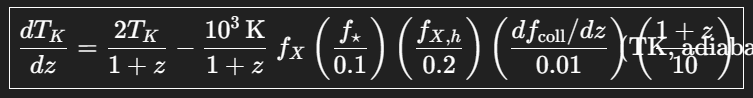

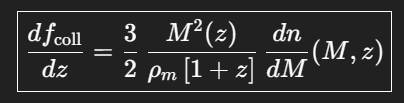

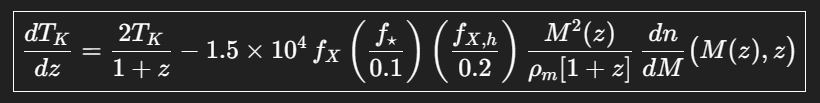

In [2]:
pip install colossus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.2/198.2 kB 4.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Colossus imports
from colossus.cosmology import cosmology
from colossus.lss import mass_function

In [4]:
# ============================================================
# 1. Cosmology setup in Colossus
# ============================================================

# Your given cosmological parameters
h        = 0.74
Omega_m  = 0.26
Omega_b  = 0.044
Omega_L  = 0.74      # implied by flatness anyway
sigma8   = 0.8
n_s      = 0.95

# Colossus expects a dict of parameters for a custom cosmology
# H0 is in km s^-1 Mpc^-1; "flat=True" enforces Omega_L = 1 - Omega_m.
cosmo_params = {
    'flat'  : True,
    'H0'    : 100.0 * h,   # H0 = 100 h km/s/Mpc
    'Om0'   : Omega_m,
    'Ob0'   : Omega_b,
    'sigma8': sigma8,
    'ns'    : n_s,
}

# Register and set this cosmology as the current one
cosmo = cosmology.setCosmology('user_cosmo', **cosmo_params)

# Mean matter density today, ρ_m(z=0); Colossus returns this in
# physical units Msun * h^2 / kpc^3. :contentReference[oaicite:1]{index=1}
rho_m0_col = cosmo.rho_m(0.0)
rho_m0     = rho_m0_col * 1.0e9 / h

In [5]:
# ============================================================
# 2. Astrophysical parameters and heating prefactor
# ============================================================

# Given astrophysical parameters
f_star = 0.1     # star formation efficiency
#f_esc  = 0.1     # escape fraction (not directly used in this ODE)
f_X    = 1.0     # X-ray efficiency
f_Xh   = 0.2     # fraction of X-ray energy into heat
mu     = 1.22    # mean molecular weight of neutral primordial gas

# Break the big prefactor into pieces for clarity.
# This is exactly the factor multiplying dn/dM in your equation.

# 1. The "1.5 x 10^4 K" piece and the astrophysical factors.
C_eps = 1.5e4 * f_X * (f_star / 0.1) * (f_Xh / 0.2)

# 2. The 10^16 h^-2 Msun^2 / (ρ_m Ω_m) part.
# We include the h^-2 factor explicitly, and use rho_m0 from Colossus.
#C_mass = 1.0e16 * h**(-2) / (rho_m0 * Omega_m)

# 3. The [10/1.98 (0.6/μ)]^3 part.
#C_mu = (10.0 / 1.98 * (0.6 / mu)) ** 3

# Total prefactor that multiplies dn/dM in the ODE
K_prefactor = C_eps

In [6]:
# ============================================================
# 3. Minimum halo mass M_min(z) (atomic cooling threshold)
# ============================================================

def M_min_atomic(z, T_vir=1.0e4):
    """
    Approximate minimum halo mass (in Msun/h) that can cool via atomic
    hydrogen given a virial temperature threshold T_vir ~ 1e4 K.

    Here we follow the usual Furlanetto et al.-style scaling:
       M_min ~ 10^8 Msun/h * (T_vir / 1.98e4 K)^(3/2)
                                * (0.6 / mu)^(3/2) * ((1+z)/10)^(-3/2)

    We ignore the mild Ω_m(z) and Δ_c(z) corrections for simplicity,
    consistent with how your ODE lumps those into the prefactor.
    """
    z = np.asarray(z)
    factor_T  = (T_vir * 10 / 1.98e4) ** 1.5
    factor_mu = (0.6 / mu) ** 1.5
    factor_z = (Omega_m *((1.0 + z)**3))**(-0.5)
    return 1.0e8 * factor_T * factor_mu * factor_z  # Msun/h #modify according to my formula

In [7]:
# ============================================================
# 4. Press–Schechter halo mass function dn/dM at M = M_min(z)
# ============================================================

def dn_dM_PS(z):
    """
    Return dn/dM evaluated at M = M_min(z) using the Press & Schechter
    (1974) halo mass function.

    Colossus API reminder: mass_function.massFunction(x, z, ...)
    - x: halo mass in Msun/h when q_in='M'.
    - model='press74' selects Press & Schechter. :contentReference[oaicite:2]{index=2}
    - q_out='dndlnM' returns dn/dlnM in units (Mpc/h)^(-3).

    We then convert dn/dlnM -> dn/dM via:
        dn/dM = (1/M) * dn/dlnM
    because d ln M = dM / M.
    """
    M = M_min_atomic(z)  # Msun/h

    # Colossus can take scalar or numpy array for M.
    mfunc_dndlnM = mass_function.massFunction(
        M, z,
        mdef='fof',       # FoF mass definition, valid for press74
        model='press74',  # Press & Schechter 1974
        q_out='dndlnM'    # output: dn/dlnM
    )

    dn_dM = mfunc_dndlnM / M
    return dn_dM  # units: (Mpc/h)^(-3) / Msun

In [8]:
def f_coll(z):
    Mmin = M_min_atomic(z)
    Mmax = 1e15  # Msun/h, upper integration limit
    M    = np.logspace(np.log10(Mmin), np.log10(Mmax), 400)
    #use the colossus press74 mass function
    mfunc_dndlnM = mass_function.massFunction(
        M, z, mdef='fof', model='press74', q_out='dndlnM'
    )  # units: (Mpc/h)^-3 / Msun
    dn_dM = mfunc_dndlnM / M
    integrand = M * dn_dM
    integral  = np.trapz(integrand, M)  # Msun * (Mpc/h)^-3
    return integral / rho_m0           # dimensionless collapsed fraction

In [9]:
def dfcoll_dz(z):
    dz = 0.05 * (1.0 + z)
    return (f_coll(z + 0.5*dz) - f_coll(z - 0.5*dz)) / dz

In [10]:
def dTk_dz2(z, Tk):
    adiabatic = 2.0 * Tk / (1.0 + z)
    heating   = 100.0 * f_X * (f_star/0.1) * (f_Xh/0.2) * (dfcoll_dz(z)/0.01) * (1.0 + z)
    return adiabatic + heating

In [11]:
def Tk_adiabatic(z, z_dec=150.0, Tcmb0=2.725):
    """
    Adiabatic evolution of the gas temperature after Compton decoupling.

    At decoupling (z_dec ~ 150), we have T_K ≈ T_CMB = Tcmb0 * (1+z_dec).
    After that, gas cools as (1+z)^2, so:

       T_K(z) = T_CMB(z_dec) * [(1+z)/(1+z_dec)]^2.

    This gives you a physically reasonable initial condition for T_K at
    z = 25 before significant X-ray heating.
    """
    T_dec = Tcmb0 * (1.0 + z_dec)
    return T_dec * ((1.0 + z) / (1.0 + z_dec)) ** 2

# Redshift range
z_start = 25.0
z_end   = 5.0

# Initial T_K at z_start (roughly adiabatic)
Tk_initial = Tk_adiabatic(z_start)

In [12]:
# ============================================================
# 7. Integrate the ODE from z = 25 down to z = 5
# ============================================================

def integrate_Tk():
    # Grid of redshifts at which we want the solution
    z_eval = np.linspace(z_start, z_end, 400)

    # solve_ivp integrates y'(z) = f(z,y).
    # It allows z to decrease: t_span=(z_start, z_end).
    sol = solve_ivp(
        dTk_dz2,
        t_span=(z_start, z_end),
        y0=[Tk_initial],
        t_eval=z_eval,
        rtol=1e-5,
        atol=1e-7,
        dense_output=False,
    )

    if not sol.success:
        raise RuntimeError("ODE integrator failed: " + sol.message)

    # sol.y is shape (n_eqs, n_points); here n_eqs=1
    return z_eval, sol.y[0]

def T_gamma(z, Tcmb0=2.725):
    """CMB temperature in K: T_gamma(z) = Tcmb0 * (1 + z)."""
    z = np.asarray(z)
    return Tcmb0 * (1.0 + z)

/tmp/ipython-input-626072876.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral  = np.trapz(integrand, M)  # Msun * (Mpc/h)^-3
/tmp/ipython-input-326015835.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1000)


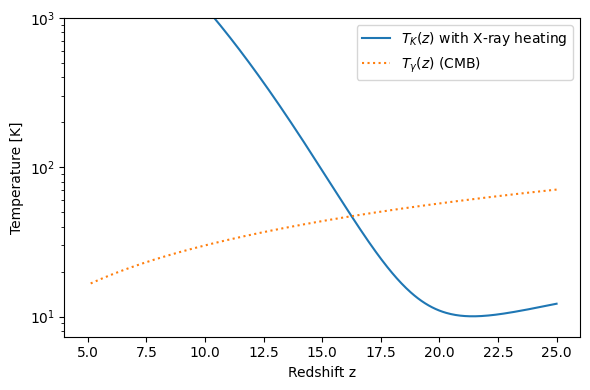

In [13]:
# ============================================================
# 8. Main script: compute and plot T_K(z)
# ============================================================

if __name__ == "__main__":
    z_vals, Tk_vals = integrate_Tk()

    plt.figure(figsize=(6, 4))

    # Numerical solution including X-ray heating
    plt.plot(z_vals, Tk_vals, label=r"$T_K(z)$ with X-ray heating")

    # NEW: CMB temperature curve
    plt.plot(
        z_vals,
        T_gamma(z_vals),
        linestyle=":",
        label=r"$T_\gamma(z)$ (CMB)"
    )

    # Make y-axis logarithmic
    plt.yscale("log")

    # Set y-axis limits to cutoff at 10^3
    plt.ylim(0, 1000)

    # Put high redshift on the left
    #plt.gca().invert_xaxis()

    plt.xlabel("Redshift z")
    plt.ylabel(r"Temperature [K]")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Physical constants (cgs)
# -------------------------------
c      = 2.99792458e10   # speed of light [cm/s]
h_planck = 6.62607015e-27 # Planck constant [erg*s]
k_B    = 1.380649e-16    # Boltzmann constant [erg/K]
m_p    = 1.6726219e-24   # proton mass [g]
e_charge = 4.80320425e-10  # electron charge [statC]
m_e    = 9.10938356e-28  # electron mass [g]
pi     = np.pi

# Cosmology (same as your Tk code)
Omega_b = 0.044
h       = 0.74
T_CMB0  = 2.725   # CMB temperature today [K]
Y_He    = 0.24    # helium mass fraction

# ρ_crit,0 in cgs [g/cm^3]
rho_crit0 = 1.8788e-29 * h**2
rho_b0    = Omega_b * rho_crit0      # physical baryon density today [g/cm^3]

# Mean baryon number density today [cm^-3].
# For global Ly-α photons, it's standard to take μ ~ 1.22 (neutral gas).
mu_b     = 1.22
n_b0     = rho_b0 / (mu_b * m_p)

# Hydrogen number density today (comoving) [cm^-3]
n_H0     = (1.0 - Y_He) * n_b0

# Ly-α line properties
lambda_alpha = 1216e-8  # 1216 Å in cm
lambda_LL    = 1026e-8  # Lyman limit 912 Å in cm
nu_alpha     = c / lambda_alpha
nu_LL        = c / lambda_LL
delta_nu     = nu_LL - nu_alpha  # frequency width of Lyα–Ly limit band

# Gunn–Peterson prefactor χ_α = π e^2 f_α / (m_e c)
f_alpha      = 0.4162
chi_alpha    = (pi * e_charge**2 * f_alpha) / (m_e * c)

# Pop II Lyα parameters from Furlanetto
f_star    = 0.1   # star formation efficiency
f_rec_bar = 0.72  # effective recycling fraction into Lyα
N_alpha   = 9690  # Lyα-band photons per baryon

# Assume neutral hydrogen fraction before reionization
def x_HI_of_z(z):
    return 1.0

# CMB temperature
def T_gamma_of_z(z):
    return T_CMB0 * (1.0 + z)


In [15]:
H0 = 100.0 * h * 1.0e5 / 3.08567758128e24   # [s^-1]


def Hubble(z):
    """
    H(z) in cgs units [s^-1] for a flat ΛCDM cosmology with
    Omega_m = 0.26, Omega_lambda = 0.74, H0 = 100 h km/s/Mpc, h = 0.74.

    Formula:
        H(z) = H0 * sqrt( Omega_m (1+z)^3 + Omega_lambda )

    We neglect radiation and curvature; this is completely fine
    for 5 <= z <= 25.
    """
    z = np.asarray(z)
    return H0 * np.sqrt(Omega_m * (1.0 + z)**3 + Omega_L)

In [16]:
"""def tau_GP_of_z(z_arr):

    Compute the Gunn–Peterson optical depth τ_GP(z) at Lyα.
    Uses:
      τ_GP = χ_α * n_HI(z) * c / [H(z) * ν_α]

    n_HI(z) = x_HI(z) * n_H0 * (1+z)^3

    z_arr = np.asarray(z_arr)
    tau_arr = np.zeros_like(z_arr)

    for i, z in enumerate(z_arr):
        x_HI = x_HI_of_z(z)  # here ~1
        n_HI = x_HI * n_H0 * (1.0 + z)**3   # physical density
        tau_arr[i] = chi_alpha * n_HI * c / (Hubble(z) * nu_alpha)

    return tau_arr"""
gamma_Lya = 6.25e8

def tau_GP_of_z(z_arr):
    """
    Compute the Gunn–Peterson optical depth τ_GP(z) at Lyα using

        τ_GP = 3 n_H x_HI λ_Lyα^3 γ / (2 H)

    where
      n_H(z)  = n_H0 (1+z)^3  is the physical hydrogen number density,
      x_HI(z) is the neutral fraction (here ~1),
      λ_Lyα   is the Lyα wavelength in cm,
      γ       is the Lyα damping rate (≈ 6.25e8 s^-1),
      H(z)    is the Hubble rate in s^-1.

    Returns:
      tau_arr : array of τ_GP(z), dimensionless.
    """
    z_arr = np.asarray(z_arr, dtype=float)
    tau_arr = np.zeros_like(z_arr, dtype=float)

    for i, z in enumerate(z_arr):
        x_HI = x_HI_of_z(z)                    # neutral fraction
        n_H  = n_H0 * (1.0 + z)**3            # physical hydrogen density [cm^-3]
        H_z  = Hubble(z)                      # [s^-1]

        tau_arr[i] = (3.0 * n_H * x_HI * lambda_alpha**3 * gamma_Lya) / (2.0 * H_z)

    return tau_arr



def xi_param(Tk_arr, tau_GP_arr):
    """
    Compute ξ(z) = (1e-7 τ_GP)^(1/3) * T_k^(-2/3)
    Input:
      Tk_arr:   kinetic temperature [K]
      tau_GP_arr: Gunn–Peterson optical depth (dimensionless)
    """
    Tk_arr = np.asarray(Tk_arr)
    tau_GP_arr = np.asarray(tau_GP_arr)

    return (1e-7 * tau_GP_arr)**(1.0/3.0) * Tk_arr**(-2.0/3.0)


In [23]:
def compute_delta_fcoll(z_arr, fcoll_arr):
    """
    Correct: Δf_coll at index i measures growth in f_coll
    between the previous (higher-z) bin and this (lower-z) bin.
    Assumes z_arr is sorted high -> low.
    """
    z_arr = np.asarray(z_arr)
    fcoll_arr = np.asarray(fcoll_arr)

    N = len(z_arr)
    delta_fcoll = np.zeros_like(fcoll_arr)

    # For the first point, just copy the next one (or use one-sided diff)
    delta_fcoll[0] = 0.0

    for i in range(1, N):
        # growth from z_{i-1} (higher z) to z_i (lower z)
        df = fcoll_arr[i] - fcoll_arr[i - 1]
        delta_fcoll[i] = max(df, 0.0)

    return delta_fcoll


def compute_J_alpha(z_arr, fcoll_arr):
    """
    Compute J_alpha(z) using Furlanetto's approximate formula:

      J_alpha(z) ≈ (c / 4π) * f_rec_bar * f_star * n_b0 *
                    Δf_coll(z) * (N_alpha / Δν) * (1+z)^2

    Returns J_alpha_arr with same shape as z_arr.
    Units: photons cm^-2 s^-1 Hz^-1 sr^-1.
    """
    z_arr = np.asarray(z_arr)
    fcoll_arr = np.asarray(fcoll_arr)

    prefactor = (c / (4.0 * pi)) * f_rec_bar * f_star * n_b0 * (N_alpha / delta_nu)

    J_alpha_arr = prefactor * fcoll_arr * (1.0 + z_arr)**2
    return J_alpha_arr * 10


In [24]:
def S_alpha_tilde(Tk, Ts, xi):
    """
    Spectral correction factor S̃_α(Tk, Ts, ξ) as in your formula.

    All temperatures in Kelvin, xi dimensionless.
    """
    Tk = float(Tk)
    Ts = float(Ts)
    xi = float(xi)

    # First polynomial in Tk^{-1}, Tk^{-2}, Ts^{-1} Tk^{-1}, Ts^{-2} Tk^{-2}
    inv_Tk  = 1.0 / Tk
    inv_Tk2 = inv_Tk**2
    inv_Ts  = 1.0 / Ts
    inv_Ts2 = inv_Ts**2

    poly_T = (1.0
              - 0.0631789 * inv_Tk
              + 0.115995  * inv_Tk2
              - 0.401403  * inv_Ts * inv_Tk
              + 0.336463  * inv_Ts * inv_Tk2)

    # Second polynomial in ξ
    poly_xi = (1.0
               + 2.98394 * xi
               + 1.53583 * xi**2
               + 3.85289 * xi**3)

    return poly_T / poly_xi


In [25]:
def x_alpha_tilde_single(z, Tk, Ts, J_alpha, xi):
    """
    Compute x̃_α(z) for a *single* redshift, given:
      z        : redshift
      Tk       : kinetic temperature [K]
      Ts       : spin temperature [K] (current iterate)
      J_alpha  : Lyα intensity at this z
      xi       : ξ parameter at this z

    x̃_α = 1.81e11 * (1+z)^(-1) * S̃_α(Tk, Ts, ξ) * J_α
    """
    S_tilde = S_alpha_tilde(Tk, Ts, xi)
    return 1.81e11 * (1.0 + z)**(-1.0) * S_tilde * J_alpha

In [26]:
def solve_Ts_at_z(z, Tk, Tgamma, J_alpha, xi,
                  x_c=0.0,
                  T_init_mode="Tk",
                  tol_rel=1e-4,
                  max_iter=150):
    """
    Solve for Ts at a *single* redshift z via fixed-point iteration.

    Inputs:
      z        : redshift
      Tk       : kinetic temperature [K]
      Tgamma   : CMB temperature [K]
      J_alpha  : Lyα intensity at this z
      xi       : ξ parameter at this z
      x_c      : collisional coupling (we set ~0 for IGM here)
      T_init_mode : "Tk" or "Tgamma" to choose initial guess
      tol_rel  : relative convergence tolerance
      max_iter : maximum iterations

    Returns:
      Ts       : converged spin temperature [K]
    """

    # Initial guess for Ts: either Tk or Tgamma are reasonable
    if T_init_mode == "Tk":
        Ts = Tk
    else:
        Ts = Tgamma

    for _ in range(max_iter):
        Ts_old = Ts

        # Compute x̃_α using current Ts
        x_alpha_tilde = x_alpha_tilde_single(z, Tk, Ts_old, J_alpha, xi)

        # Total coupling x_tot = x_c + x̃_α
        x_tot = x_c + x_alpha_tilde

        # Update Ts from spin-temperature formula:
        # 1/Ts = (Tγ^{-1} + x_tot * Tk^{-1}) / (1 + x_tot)
        inv_Tgamma = 1.0 / Tgamma
        inv_Tk     = 1.0 / Tk

        inv_Ts = (inv_Tgamma + x_tot * inv_Tk) / (1.0 + x_tot)
        Ts = 1.0 / inv_Ts

        # Check relative convergence
        if abs(Ts - Ts_old) / Ts_old < tol_rel:
            break

    return Ts


In [29]:
def compute_Ts_grid(z_arr, Tk_arr, J_alpha_arr, tau_GP_arr,
                    x_c_arr=None,
                    T_init_mode="Tk",
                    tol_rel=1e-4,
                    max_iter=150):
    """
    Compute Ts(z) on a grid using fixed-point iteration at each z.

    Inputs:
      z_arr        : 1D array of redshifts
      Tk_arr       : kinetic temperature array [K]
      J_alpha_arr  : Lyα intensity array
      tau_GP_arr   : τ_GP(z) array
      x_c_arr      : optional collisional coupling x_c(z); if None, use zeros
      T_init_mode  : initial guess for Ts ("Tk" or "Tgamma")
      tol_rel      : relative tol for Ts convergence
      max_iter     : maximum iterations per z

    Returns:
      Ts_arr       : spin temperature array [K]
    """
    z_arr = np.asarray(z_arr)
    Tk_arr = np.asarray(Tk_arr)
    J_alpha_arr = np.asarray(J_alpha_arr)
    tau_GP_arr = np.asarray(tau_GP_arr)

    if x_c_arr is None:
        x_c_arr = np.zeros_like(z_arr)

    # Compute ξ from τ_GP and Tk
    xi_arr = xi_param(Tk_arr, tau_GP_arr)

    Ts_arr = np.zeros_like(Tk_arr)

    for i, z in enumerate(z_arr):
        Tk     = Tk_arr[i]
        Tgamma = T_gamma_of_z(z)
        J_a    = J_alpha_arr[i]
        xi     = xi_arr[i]
        x_c    = x_c_arr[i]

        Ts_arr[i] = solve_Ts_at_z(
            z, Tk, Tgamma, J_a, xi,
            x_c=x_c,
            T_init_mode=T_init_mode,
            tol_rel=tol_rel,
            max_iter=max_iter
        )

    return Ts_arr


/tmp/ipython-input-626072876.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral  = np.trapz(integrand, M)  # Msun * (Mpc/h)^-3
/tmp/ipython-input-2351509967.py:35: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1000)


<Figure size 600x400 with 0 Axes>

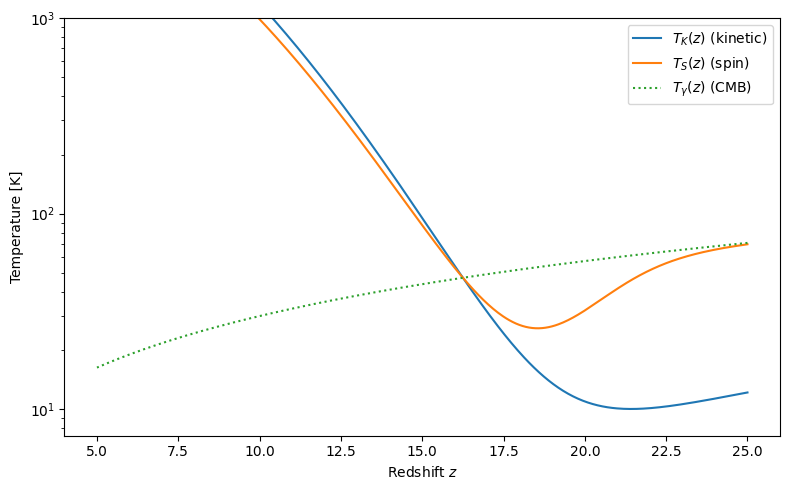

In [30]:
# -------------------------------
# 1. Prepare Δf_coll and J_alpha
# -------------------------------
if __name__ == "__main__":
    z_vals, Tk_vals = integrate_Tk()

    plt.figure(figsize=(6, 4))
    fcoll_arr = np.array([f_coll(z) for z in z_vals])
    #fcoll_arr = f_coll(z_vals)
    #delta_fcoll_arr = compute_delta_fcoll(z_vals, fcoll_arr)
    J_alpha_arr     = compute_J_alpha(z_vals, fcoll_arr)

    # -------------------------------
    # 2. Compute τ_GP and Ts grid
    # -------------------------------
    tau_GP_arr = tau_GP_of_z(z_vals)
    Ts_arr     = compute_Ts_grid(z_vals, Tk_vals, J_alpha_arr, tau_GP_arr)

    # For reference, CMB temperature on the same grid
    Tgamma_arr = T_gamma_of_z(z_vals)

    # -------------------------------
    # 3. Plot Tk, Ts, and Tγ
    # -------------------------------
    plt.figure(figsize=(8, 5))

    plt.plot(z_vals, Tk_vals,      label=r"$T_K(z)$ (kinetic)")
    plt.plot(z_vals, Ts_arr,      label=r"$T_S(z)$ (spin)")
    plt.plot(z_vals, Tgamma_arr, linestyle=":", label=r"$T_\gamma(z)$ (CMB)")

    plt.yscale("log")
    #plt.gca().invert_xaxis()  # high z on the left, like Furlanetto

    # Set y-axis limits to cutoff at 10^3
    plt.ylim(0, 1000)

    plt.xlabel(r"Redshift $z$")
    plt.ylabel(r"Temperature [K]")
    plt.legend()
    plt.tight_layout()
    plt.show()